<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Asssignment%2011/VAE_in_BCE_and_MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.13MB/s]


In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 400)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [3]:
def loss_function(recon_x, x, mu, logvar, recon_loss_type="bce"):
    if recon_loss_type == "bce":
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    elif recon_loss_type == "mse":
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    else:
        raise ValueError("recon_loss_type must be 'bce' or 'mse'")

    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div, recon_loss, kl_div


In [4]:
def train_vae(model, train_loader, optimizer, recon_loss_type="bce", epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon, kl = loss_function(recon_batch, data, mu, logvar, recon_loss_type)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


In [5]:
def show_reconstructions(model, test_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            imgs, _ = batch
            imgs = imgs.to(device)
            recon, _, _ = model(imgs)
            break

    imgs = imgs[:num_images].cpu()
    recon = recon[:num_images].cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[0, i].imshow(imgs[i].squeeze(), cmap="gray")
        axs[1, i].imshow(recon[i].squeeze(), cmap="gray")
        axs[0, i].axis("off")
        axs[1, i].axis("off")
    axs[0, 0].set_title("Originals")
    axs[1, 0].set_title("Reconstructions")
    plt.tight_layout()
    plt.show()


Training VAE with BCE loss:
Epoch 1, Loss: 192.0890
Epoch 2, Loss: 167.7502
Epoch 3, Loss: 164.2393
Epoch 4, Loss: 162.4632
Epoch 5, Loss: 160.9140
Epoch 6, Loss: 159.6735
Epoch 7, Loss: 158.6165
Epoch 8, Loss: 157.6813
Epoch 9, Loss: 156.8196
Epoch 10, Loss: 156.0939


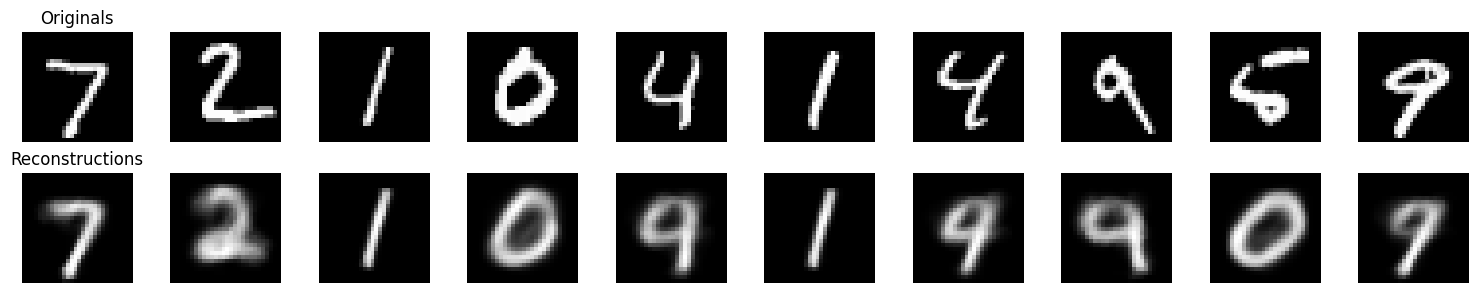

Training VAE with MSE loss:
Epoch 1, Loss: 48.8389
Epoch 2, Loss: 42.6526
Epoch 3, Loss: 41.6757
Epoch 4, Loss: 41.1193
Epoch 5, Loss: 40.6752
Epoch 6, Loss: 40.3197
Epoch 7, Loss: 39.9986
Epoch 8, Loss: 39.7519
Epoch 9, Loss: 39.5546
Epoch 10, Loss: 39.3408


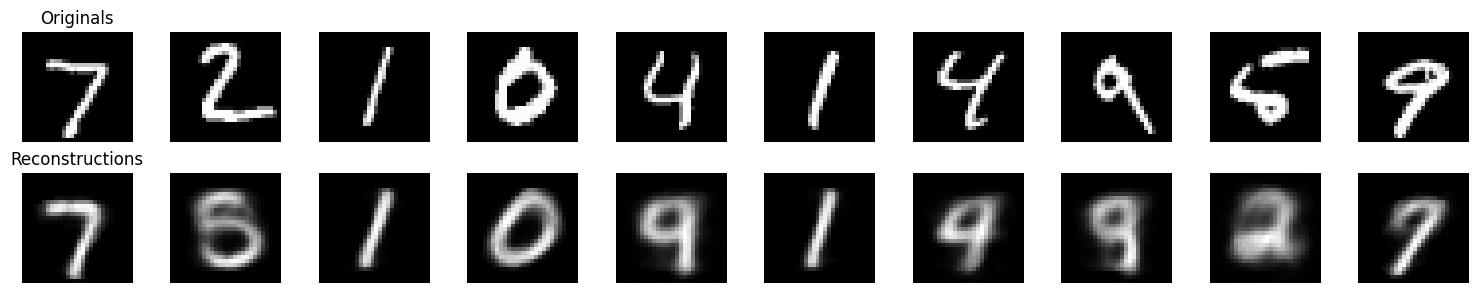

In [6]:
# BCE VAE
vae_bce = VAE().to(device)
opt_bce = torch.optim.Adam(vae_bce.parameters(), lr=1e-3)
print("Training VAE with BCE loss:")
train_vae(vae_bce, train_loader, opt_bce, recon_loss_type="bce", epochs=10)
show_reconstructions(vae_bce, test_loader)

# MSE VAE
vae_mse = VAE().to(device)
opt_mse = torch.optim.Adam(vae_mse.parameters(), lr=1e-3)
print("Training VAE with MSE loss:")
train_vae(vae_mse, train_loader, opt_mse, recon_loss_type="mse", epochs=10)
show_reconstructions(vae_mse, test_loader)
